In [1]:
# pip install -r requirements.txt
%pip install -r ../requirements.txt --user --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext pretty_jupyter

# Introduction

In diesem Notebook wenden wir Applied Machine Learning (AML) Techniken an, um effektive Strategien für personalisierte Kreditkarten-Werbekampagnen zu entwickeln. Unser Ziel ist es, mithilfe von Kunden- und Transaktionsdaten präzise Modelle zu erstellen, die die Wahrscheinlichkeit des Kreditkartenkaufs vorhersagen.

## Lib Importing


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from itables import init_notebook_mode
from datetime import datetime

init_notebook_mode(all_interactive=False)

<IPython.core.display.Javascript object>

## Load the Data



In [4]:
account = pd.read_csv("account.csv", sep=";", dtype={"date": "str"})
account["date"] = pd.to_datetime(account["date"], format="%y%m%d")

card = pd.read_csv("card.csv", sep=";", dtype={"issued": "str"})
# Man kann die Zeit weglassen da immer 00:00:00
card["issued"] = pd.to_datetime(card["issued"].str[:6], format="%y%m%d")

client = pd.read_csv("client.csv", sep=";")
disp = pd.read_csv("disp.csv", sep=";")
district = pd.read_csv("district.csv", sep=";")

loan = pd.read_csv("loan.csv", sep=";", dtype={"date": "str"})
loan["date"] = pd.to_datetime(loan["date"], format="%y%m%d")


order = pd.read_csv("order.csv", sep=";")

trans = pd.read_csv("trans.csv", sep=";", dtype={"date": "str", "bank": "str"})
trans["date"] = pd.to_datetime(trans["date"], format="%y%m%d")
trans
# count 'NaN' in each column from trans

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1056315,3626622,2906,1998-12-31,PRIJEM,NaN,62.3,13729.4,UROK,NaN,NaN
1056316,3627616,2935,1998-12-31,PRIJEM,NaN,81.3,19544.9,UROK,NaN,NaN
1056317,3625403,2869,1998-12-31,PRIJEM,NaN,60.2,14638.2,UROK,NaN,NaN
1056318,3626683,2907,1998-12-31,PRIJEM,NaN,107.5,23453.0,UROK,NaN,NaN


## EDA

### Account

In [5]:
account

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,1993-01-01
1,3818,74,POPLATEK MESICNE,1993-01-01
2,704,55,POPLATEK MESICNE,1993-01-01
3,2378,16,POPLATEK MESICNE,1993-01-01
4,2632,24,POPLATEK MESICNE,1993-01-02
...,...,...,...,...
4495,124,55,POPLATEK MESICNE,1997-12-28
4496,3958,59,POPLATEK MESICNE,1997-12-28
4497,777,30,POPLATEK MESICNE,1997-12-28
4498,1573,63,POPLATEK MESICNE,1997-12-29


### Card

In [6]:
card

,card_id,disp_id,type,issued
0,1005,9285,classic,1993-11-07
1,104,588,classic,1994-01-19
2,747,4915,classic,1994-02-05
3,70,439,classic,1994-02-08
4,577,3687,classic,1994-02-15
...,...,...,...,...
887,125,694,gold,1998-12-26
888,674,4360,classic,1998-12-28
889,322,2063,classic,1998-12-28
890,685,4467,classic,1998-12-29


### Client

In [7]:
client

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5
...,...,...,...
5364,13955,456030,1
5365,13956,430406,1
5366,13968,680413,61
5367,13971,626019,67


### Disp

In [8]:
disp

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT
...,...,...,...,...
5364,13647,13955,11349,OWNER
5365,13648,13956,11349,DISPONENT
5366,13660,13968,11359,OWNER
5367,13663,13971,11362,OWNER


### District

In [9]:
district

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
74,75,Prerov,north Moravia,138032,67,30,4,2,5,64.6,8819,5.38,5.66,99,4063,4505
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107,3736,2807


### Loan

In [10]:
loan

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A
...,...,...,...,...,...,...,...
677,4989,105,1998-12-05,352704,48,7348.0,C
678,5221,1284,1998-12-05,52512,12,4376.0,C
679,6402,6922,1998-12-06,139488,24,5812.0,C
680,5346,1928,1998-12-06,55632,24,2318.0,C


### Order

In [11]:
order

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,
...,...,...,...,...,...,...
6466,46334,11362,YZ,70641225,4780.0,SIPO
6467,46335,11362,MN,78507822,56.0,
6468,46336,11362,ST,40799850,330.0,POJISTNE
6469,46337,11362,KL,20009470,129.0,


### Trans

In [12]:
trans

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1056315,3626622,2906,1998-12-31,PRIJEM,NaN,62.3,13729.4,UROK,NaN,NaN
1056316,3627616,2935,1998-12-31,PRIJEM,NaN,81.3,19544.9,UROK,NaN,NaN
1056317,3625403,2869,1998-12-31,PRIJEM,NaN,60.2,14638.2,UROK,NaN,NaN
1056318,3626683,2907,1998-12-31,PRIJEM,NaN,107.5,23453.0,UROK,NaN,NaN


## Transformations

In [13]:
data_frames = {}

### Account


In [14]:
# Frequency Transformation
account["frequency"] = account["frequency"].replace(
    {
        "POPLATEK MESICNE": "monthly issuance",
        "POPLATEK TYDNE": "weekly issuance",
        "POPLATEK PO OBRATU": "issuance after transaction",
    }
)

# Rename Column
account = account.rename(columns={"frequency": "issuance_statement_frequency"})

# Convert Date Column to datetime format
account["date"] = pd.to_datetime(account["date"])

# Assuming 'data_frames' is a dictionary of DataFrames
data_frames["account.csv"] = account

# Sample 5 random rows
account.sample(n=5)

,account_id,district_id,issuance_statement_frequency,date
1309,4195,67,monthly issuance,1994-05-21
2772,2190,41,weekly issuance,1996-06-04
827,837,46,monthly issuance,1993-09-18
3135,1894,6,monthly issuance,1996-08-29
4412,1866,4,monthly issuance,1997-11-17


### Card

In [15]:
card["issued"] = pd.to_datetime(card["issued"], format="mixed")
data_frames["card.csv"] = card

### Client

In [16]:
# Funktion zur Bestimmung des Geschlechts und Berechnung des Geburtstags
def parse_details(birth_number):
    birth_number_str = str(
        birth_number
    )  # Konvertiere birth_number zu einem String, falls notwendig
    year_prefix = "19"
    month = int(birth_number_str[2:4])
    gender = "female" if month > 12 else "male"
    if gender == "female":
        month -= 50
    year = int(year_prefix + birth_number_str[:2])
    day = int(birth_number_str[4:6])
    birth_day = datetime(year, month, day)
    return gender, birth_day


# Berechnung des Alters basierend auf einem Basisjahr
def calculate_age(birth_date, base_date=datetime(1999, 12, 31)):
    return (
        base_date.year
        - birth_date.year
        - ((base_date.month, base_date.day) < (birth_date.month, birth_date.day))
    )


# Anwenden der Funktionen und Erstellen neuer Spalten
client["gender"], client["birth_day"] = zip(
    *client["birth_number"].apply(parse_details)
)
client["age"] = client["birth_day"].apply(calculate_age)

data_frames["client.csv"] = client

# Auswahl spezifischer Spalten für die finale DataFrame (optional, je nach Bedarf)
# Sample 5 random rows
client.sample(n=5)

,client_id,birth_number,district_id,gender,birth_day,age
5275,12729,680321,36,male,1968-03-21,31
237,253,475512,48,female,1947-05-12,52
639,671,715227,10,female,1971-02-27,28
3662,3869,465224,17,female,1946-02-24,53
657,689,640802,70,male,1964-08-02,35


### Disp

In [17]:
data_frames["disp.csv"] = disp

# random sample
disp.sample(n=5)

,disp_id,client_id,account_id,type
3588,3790,3790,3134,OWNER
3066,3239,3239,2684,OWNER
2843,3003,3003,2488,OWNER
2662,2817,2817,2329,OWNER
3238,3422,3422,2831,OWNER


### District


- A1 district_id/district code
- A2 district name
- A3 region
- A4 no. of inhabitants
- A5 no. of municipalities with inhabitants < 499
- A6 no. of municipalities with inhabitants 500-1999 A7 no. of municipalities with inhabitants 2000-9999
- A8 no. of municipalities with inhabitants >10000
- A9 no. of cities
- A10 ratio of urban inhabitants
- A11 average salary
- A12 unemploymant rate ’95
- A13 unemploymant rate ’96
- A14 no. of enterpreneurs per 1000 inhabitants
- A15 no. of commited crimes ’95
- A16 no. of commited crimes ’96

In [18]:
import pandas as pd

# Assuming 'district' is your pandas DataFrame

# Renaming and selecting columns
district = district.rename(
    columns={
        "A1": "district_id",
        "A2": "district_name",
        "A3": "region",
        "A4": "num_of_habitat",
        "A5": "num_of_small_town",
        "A6": "num_of_medium_town",
        "A7": "num_of_big_town",
        "A8": "num_of_bigger_town",
        "A9": "num_of_city",
        "A10": "ratio_of_urban",
        "A11": "average_salary",
        "A12": "unemploy_rate95",
        "A13": "unemploy_rate96",
        "A14": "n_of_enterpren_per1000_inhabit",
        "A15": "no_of_crimes95",
        "A16": "no_of_crimes96",
    }
)[
    [
        "district_id",
        "district_name",
        "region",
        "num_of_habitat",
        "num_of_small_town",
        "num_of_medium_town",
        "num_of_big_town",
        "num_of_bigger_town",
        "num_of_city",
        "ratio_of_urban",
        "average_salary",
        "unemploy_rate95",
        "unemploy_rate96",
        "n_of_enterpren_per1000_inhabit",
        "no_of_crimes95",
        "no_of_crimes96",
    ]
]

data_frames["district.csv"] = district

district.sample(n=5)
district

,district_id,district_name,region,num_of_habitat,num_of_small_town,num_of_medium_town,num_of_big_town,num_of_bigger_town,num_of_city,ratio_of_urban,average_salary,unemploy_rate95,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
74,75,Prerov,north Moravia,138032,67,30,4,2,5,64.6,8819,5.38,5.66,99,4063,4505
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107,3736,2807


In [19]:
# find the ? in the district dataframe
district[district.isin(["?"]).any(axis=1)]

,district_id,district_name,region,num_of_habitat,num_of_small_town,num_of_medium_town,num_of_big_town,num_of_bigger_town,num_of_city,ratio_of_urban,average_salary,unemploy_rate95,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,?,7.01,124,?,1358


In [20]:
# replace the ? with NaN
district = district.replace("?", np.nan)

In [21]:
# replace the NaN with the mean of the column no_of_crimes95 and unemploy_rate95
district["no_of_crimes95"] = district["no_of_crimes95"].astype(float)
district["unemploy_rate95"] = district["unemploy_rate95"].astype(float)
district["no_of_crimes95"] = district["no_of_crimes95"].fillna(
    district["no_of_crimes95"].mean()
)
district["unemploy_rate95"] = district["unemploy_rate95"].fillna(
    district["unemploy_rate95"].mean()
)
# check if there are still NaN values in no_of_crimes95 and unemploy_rate95
district[district.isin([np.nan]).any(axis=1)]

,district_id,district_name,region,num_of_habitat,num_of_small_town,num_of_medium_town,num_of_big_town,num_of_bigger_town,num_of_city,ratio_of_urban,average_salary,unemploy_rate95,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96


### Loan

In [22]:
# Convert the 'date' column to datetime format
loan["date"] = pd.to_datetime(loan["date"], format="mixed")

# Mutate the 'status' column based on conditions
loan["status"] = loan["status"].map(
    {
        "A": "contract finished",
        "B": "finished contract, loan not paid",
        "C": "running contract",
        "D": "client in debt",
    }
)

# Group by 'account_id', calculate the number of loans, and sort the results
num_of_loan_df = (
    loan.groupby("account_id")
    .size()
    .reset_index(name="num_of_loan")
    .sort_values(by="num_of_loan", ascending=False)
)

# Display the resulting DataFrame
num_of_loan_df

,account_id,num_of_loan
0,2,1
457,7890,1
449,7795,1
450,7815,1
451,7819,1
...,...,...
229,4079,1
230,4081,1
231,4099,1
232,4116,1


In [23]:
# Perform an inner join between 'loan' and 'num_of_loan_df' on 'account_id'
loan = pd.merge(loan, num_of_loan_df, on="account_id", how="inner")

# Assign the resulting DataFrame to a dictionary for storage
data_frames["loan.csv"] = loan

# Sample 5 random rows from the joined DataFrame
loan.sample(n=100)

,loan_id,account_id,date,amount,duration,payments,status,num_of_loan
363,6377,6792,1997-03-17,17184,12,1432.0,contract finished,1
350,6824,9052,1997-02-26,71976,24,2999.0,client in debt,1
360,5953,4715,1997-03-14,97176,24,4049.0,running contract,1
438,6677,8169,1997-08-12,97980,60,1633.0,running contract,1
324,5625,3189,1996-12-15,222180,60,3703.0,client in debt,1
...,...,...,...,...,...,...,...,...
563,5384,2142,1998-03-07,23328,12,1944.0,running contract,1
455,5718,3637,1997-09-01,14028,12,1169.0,contract finished,1
408,5486,2516,1997-06-13,466608,48,9721.0,running contract,1
153,6950,9591,1995-04-11,104712,24,4363.0,contract finished,1


### Order


In [24]:
# Assuming 'order' and 'account' DataFrames are already loaded

# Correctly map and fill missing values in 'k_symbol' column
order["k_symbol"] = (
    order["k_symbol"]
    .map({"POJISTNE": "Insurance Payment", "SIPO": "Household", "UVER": "Loan Payment"})
    .fillna("UNKNOWN")
)

# Merge with 'account_id_df' to ensure all accounts are represented
order = pd.merge(account[["account_id"]], order, on="account_id", how="left")

# After merging, fill missing values that may have been introduced
order["k_symbol"] = order["k_symbol"].fillna("UNKNOWN")
order["amount"] = order["amount"].fillna(0)
order["has_order"] = ~order.isna().any(axis=1)

# Aggregate 'amount' information
aggregated_amount = (
    order.groupby("account_id")
    .agg(
        sum_amount=("amount", "sum"),
        mean_amount=("amount", "mean"),
        median_amount=("amount", "median"),
        min_amount=("amount", "min"),
        max_amount=("amount", "max"),
        num_of_orders=("amount", lambda x: (x != 0).sum()),
    )
    .reset_index()
)
aggregated_amount["has_order"] = aggregated_amount["sum_amount"] != 0

# Create dummies for 'k_symbol' and ensure aggregation by 'account_id'
dummies_k_symbol = pd.get_dummies(
    order[["account_id", "k_symbol"]], columns=["k_symbol"], prefix="", prefix_sep=""
)
dummies_k_symbol = dummies_k_symbol.groupby("account_id").sum().reset_index()

# Merge 'aggregated_amount' and 'dummies_k_symbol'
merged_order = pd.merge(
    aggregated_amount, dummies_k_symbol, on="account_id", how="left"
)

# Assuming data_frames is a dictionary for storing DataFrames
data_frames["order.csv"] = merged_order

# Sample 5 random rows from the merged DataFrame
merged_order.sample(n=5)

,account_id,sum_amount,mean_amount,median_amount,min_amount,max_amount,num_of_orders,has_order,Household,Insurance Payment,Loan Payment,UNKNOWN
653,688,2509.0,2509.000000,2509.0,2509.0,2509.0,1,True,1,0,0,0
2067,2170,12317.0,4105.666667,4838.0,1468.0,6011.0,3,True,1,1,0,1
3164,3327,6193.0,3096.500000,3096.5,1923.0,4270.0,2,True,1,0,0,1
2701,2841,3536.0,3536.000000,3536.0,3536.0,3536.0,1,True,1,0,0,0
787,827,2260.0,2260.000000,2260.0,2260.0,2260.0,1,True,1,0,0,0


### Trans


In [25]:
# Convert 'date' from string to datetime
trans["date"] = pd.to_datetime(trans["date"])

# Update 'type' column
trans["type"] = trans["type"].replace({"PRIJEM": "credit", "VYDAJ": "withdrawal"})

# Update 'operation' column
trans["operation"] = trans["operation"].replace(
    {
        "VYBER KARTOU": "credit card withdrawal",
        "VKLAD": "credit in cash",
        "PREVOD Z UCTU": "collection from another bank",
        "VYBER": "cash withdrawal",
        "PREVOD NA UCET": "remittance to another bank",
    }
)

# Update 'k_symbol' column
trans["k_symbol"] = trans["k_symbol"].replace(
    {
        "POJISTNE": "insurance payment",
        "SLUZBY": "statement payment",
        "UROK": "interest credited",
        "SANKC. UROK": "sanction interest if negative balance",
        "SIPO": "household payment",
        "DUCHOD": "pension credited",
        "UVER": "loan payment",
    }
)

# Assign to a dictionary if needed (similar to list assignment in R)

data_frames["trans.csv"] = trans

# Sample 5 random rows from the DataFrame
trans.sample(n=1000)
trans

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,credit,credit in cash,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,credit,credit in cash,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,credit,credit in cash,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,credit,credit in cash,400.0,400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1056315,3626622,2906,1998-12-31,credit,NaN,62.3,13729.4,interest credited,NaN,NaN
1056316,3627616,2935,1998-12-31,credit,NaN,81.3,19544.9,interest credited,NaN,NaN
1056317,3625403,2869,1998-12-31,credit,NaN,60.2,14638.2,interest credited,NaN,NaN
1056318,3626683,2907,1998-12-31,credit,NaN,107.5,23453.0,interest credited,NaN,NaN


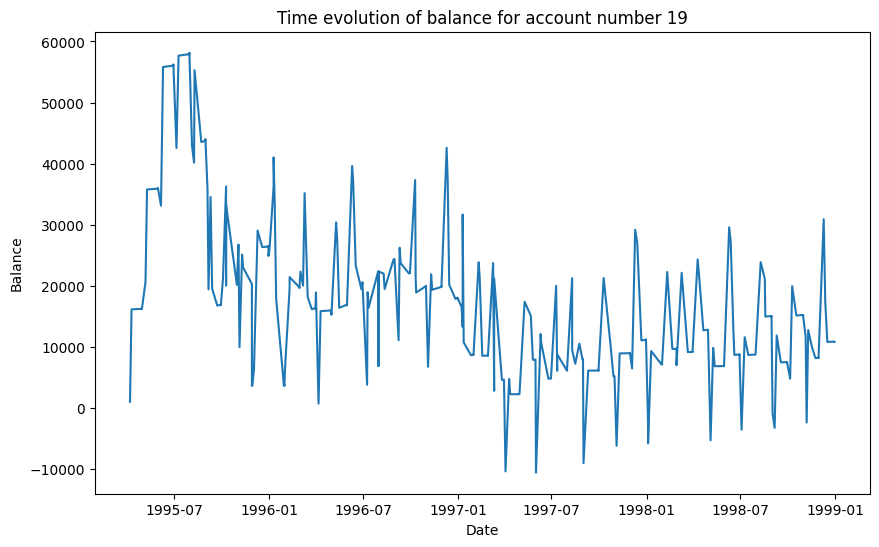

In [26]:
# Plot Zeitliche Entwicklung des Konto-Saldos für die Konto nummer 19
account_19 = trans[trans["account_id"] == 19].copy()  # Create a copy of the DataFrame
# Ensure the date column is in datetime format
account_19["date"] = pd.to_datetime(account_19["date"])

# Sort the values by date
account_19 = account_19.sort_values("date")

plt.figure(figsize=(10, 6))
plt.plot(account_19["date"], account_19["balance"])
plt.title("Time evolution of balance for account number 19")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

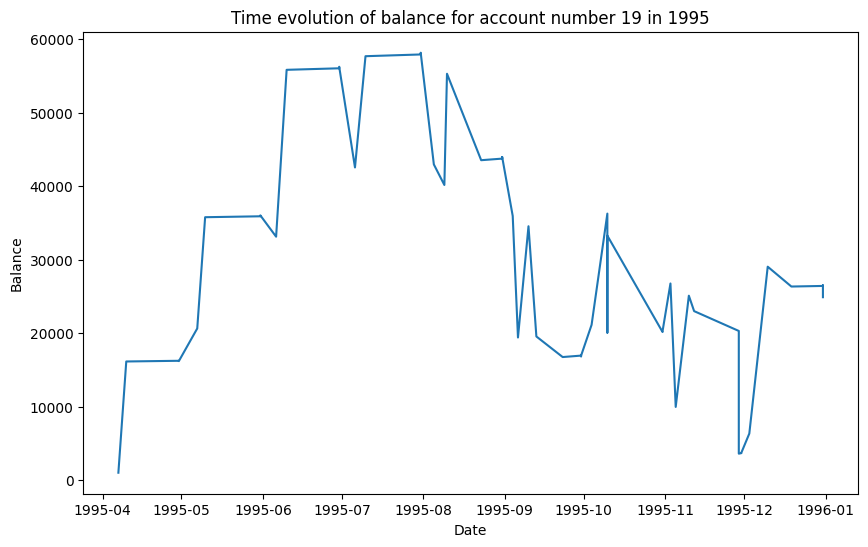

In [27]:
# zoom the year 1995 of the plot
account_19_1995 = account_19[account_19["date"].dt.year == 1995]
# plot it
plt.figure(figsize=(10, 6))
plt.plot(account_19_1995["date"], account_19_1995["balance"])
plt.title("Time evolution of balance for account number 19 in 1995")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

Wee see that there is a steep line in 1995-10 so there are two transactions, this we have to clean.

## D&Q

In [28]:
# Check for missing values in each DataFrame
for df_name, df in data_frames.items():
    print(f"Missing values in {df_name}:")
    print(df.isna().sum().sum())  # Sum of all missing values in the DataFrame

Missing values in account.csv:
0
Missing values in card.csv:
0
Missing values in client.csv:
0
Missing values in disp.csv:
0
Missing values in district.csv:
0
Missing values in loan.csv:
0
Missing values in order.csv:
0
Missing values in trans.csv:
2208738


## Dropping of Junior Cards that are not on the edge to a normal card


In [29]:
# filter cards type != "junior"
card_clean = card[card["type"] != "junior"]
card_junior = card[card["type"] == "junior"]
card_junior

,card_id,disp_id,type,issued
6,721,4680,junior,1994-04-05
12,384,2475,junior,1994-09-15
19,174,1039,junior,1994-12-04
21,763,5138,junior,1994-12-30
24,477,3082,junior,1995-01-16
...,...,...,...,...
849,657,4246,junior,1998-12-02
855,715,4639,junior,1998-12-08
863,147,826,junior,1998-12-13
864,527,3348,junior,1998-12-14


In [30]:
card

,card_id,disp_id,type,issued
0,1005,9285,classic,1993-11-07
1,104,588,classic,1994-01-19
2,747,4915,classic,1994-02-05
3,70,439,classic,1994-02-08
4,577,3687,classic,1994-02-15
...,...,...,...,...
887,125,694,gold,1998-12-26
888,674,4360,classic,1998-12-28
889,322,2063,classic,1998-12-28
890,685,4467,classic,1998-12-29


In [31]:
# inner join by client_id to disp
client_disp = pd.merge(client, disp, on="client_id", how="inner")
# left join card to client_disp
client_disp_card = pd.merge(client_disp, card, on="disp_id", how="left")
client_disp_card

,client_id,birth_number,district_id,gender,birth_day,age,disp_id,account_id,type_x,card_id,type_y,issued
0,1,706213,18,female,1970-12-13,29,1,1,OWNER,NaN,NaN,NaT
1,2,450204,1,male,1945-02-04,54,2,2,OWNER,NaN,NaN,NaT
2,3,406009,1,female,1940-10-09,59,3,2,DISPONENT,NaN,NaN,NaT
3,4,561201,5,male,1956-12-01,43,4,3,OWNER,NaN,NaN,NaT
4,5,605703,5,female,1960-07-03,39,5,3,DISPONENT,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
5364,13955,456030,1,female,1945-10-30,54,13647,11349,OWNER,NaN,NaN,NaT
5365,13956,430406,1,male,1943-04-06,56,13648,11349,DISPONENT,NaN,NaN,NaT
5366,13968,680413,61,male,1968-04-13,31,13660,11359,OWNER,1247.0,classic,1995-06-13
5367,13971,626019,67,female,1962-10-19,37,13663,11362,OWNER,NaN,NaN,NaT


C:\Users\super\AppData\Local\Temp\ipykernel_54028\3182651111.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  client_disp_card["type_y"].fillna("Missing", inplace=True)


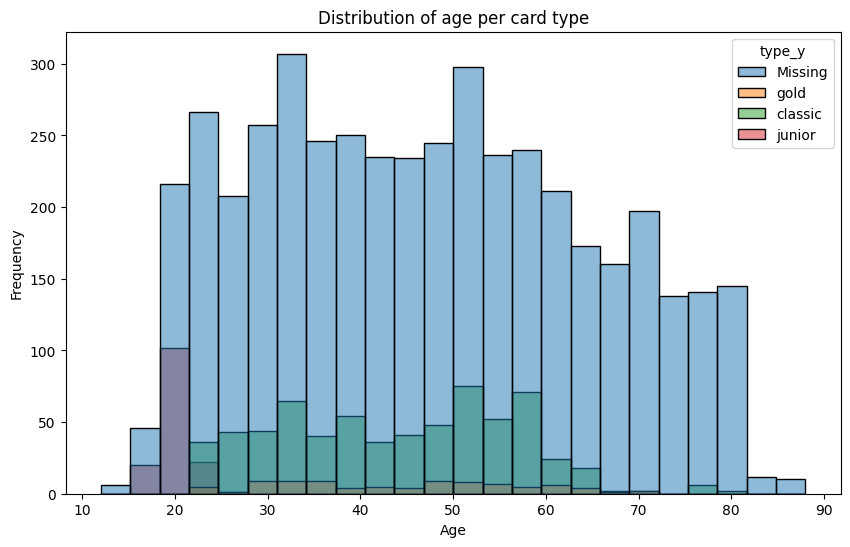

In [32]:
# Fill NaN values with "Missing"
client_disp_card["type_y"].fillna("Missing", inplace=True)

# visualize distribution of age per cardtype and NaN
plt.figure(figsize=(10, 6))
sns.histplot(client_disp_card, x="age", hue="type_y")
plt.title("Distribution of age per card type")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

Text(0.5, 0, 'Card Type')

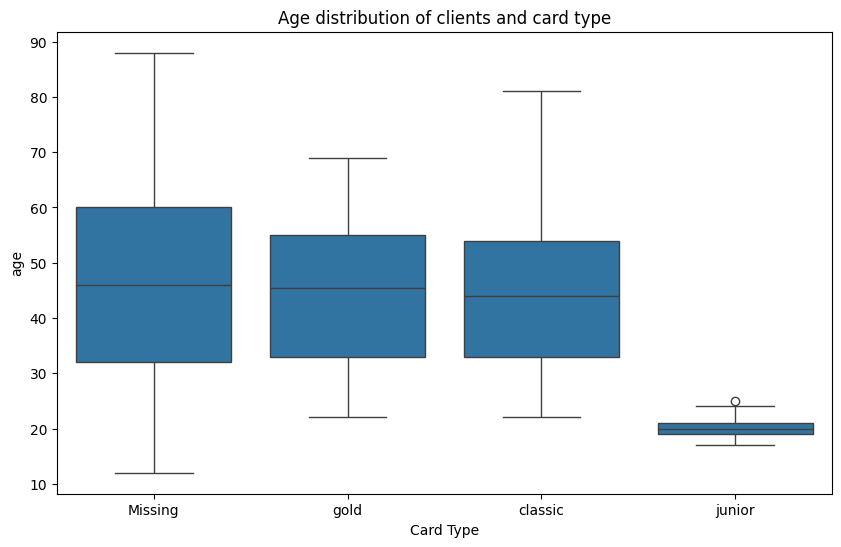

In [33]:
# box plot of the age distribution of the clients and the card type
plt.figure(figsize=(10, 6))
sns.boxplot(data=client_disp_card, x="type_y", y="age")
plt.title("Age distribution of clients and card type")
plt.xlabel("Card Type")

In [34]:
# remove all junior cards but keep NaN
client_disp_card = client_disp_card[client_disp_card["type_y"] != "junior"]

# get all account ids older than 25 years
account_older_25 = client_disp_card[client_disp_card["age"] > 25]["client_id"]


account_older_25

0           1
1           2
2           3
3           4
4           5
        ...  
5364    13955
5365    13956
5366    13968
5367    13971
5368    13998
Name: client_id, Length: 4567, dtype: int64

## Join the Dataset

### Join client und disp

In [35]:
# inner join disp and client_id but add suffixes to the columns with the table name
# Inner join client with client_ids_older_than_25 to remove junior and clients age <= 25
print(client)
client = pd.merge(client, account_older_25, on="client_id", how="inner")

# Inner join by client_id
client_disp = pd.merge(client, disp, on="client_id", suffixes=(".client", ".disp"))

# Select and rename columns
client_disp = client_disp[
    ["client_id", "district_id", "disp_id", "account_id"]
    + [
        col
        for col in client_disp.columns
        if col not in ["client_id", "district_id", "disp_id", "account_id"]
    ]
]

client_disp = client_disp.rename(
    columns={
        "year.client": "year",
        "month.client": "month",
        "day.client": "day",
        "birth_number.client": "birth_number",
        "gender.client": "gender",
        "age.client": "age",
        "type.disp": "type",
    }
)

print(f"Number of rows in client_disp df: {len(client_disp)}")

      client_id  birth_number  district_id  gender  birth_day  age
0             1        706213           18  female 1970-12-13   29
1             2        450204            1    male 1945-02-04   54
2             3        406009            1  female 1940-10-09   59
3             4        561201            5    male 1956-12-01   43
4             5        605703            5  female 1960-07-03   39
...         ...           ...          ...     ...        ...  ...
5364      13955        456030            1  female 1945-10-30   54
5365      13956        430406            1    male 1943-04-06   56
5366      13968        680413           61    male 1968-04-13   31
5367      13971        626019           67  female 1962-10-19   37
5368      13998        535812           74  female 1953-08-12   46

[5369 rows x 6 columns]
Number of rows in client_disp df: 4567


In [36]:
# filter Owner
client_disp = client_disp[client_disp["type"] == "OWNER"]

### join the card on client_disp_card

In [37]:
# inner join card to client_disp with suffix of card
client_disp_card = pd.merge(
    client_disp, card, on="disp_id", how="left", suffixes=(".disp", ".card")
)
print(f"Number of rows in client_disp_card df: {len(client_disp_card)}")


Number of rows in client_disp_card df: 3785


In [38]:
# join account to client_disp_card
client_disp_card_account = pd.merge(
    client_disp_card,
    account,
    on="account_id",
    how="inner",
    suffixes=(".client", ".account"),
)
print(f"Number of rows in client_disp_card_account df: {len(client_disp_card_account)}")

Number of rows in client_disp_card_account df: 3785


In [39]:
# left join account und loan
account_loan = pd.merge(
    account, loan, on="account_id", how="left", suffixes=(".account", ".loan")
)
print(f"Number of rows in account_loan df: {len(account_loan)}")

Number of rows in account_loan df: 4500


In [40]:
# replace NaN values in status with "no_loan"
account_loan["status"] = account_loan["status"].fillna("no_loan")
print(f"Number of rows in account_loan df: {len(account_loan)}")
# filter account_loan with status == "no_loan"
account_loan_no_loan = account_loan[account_loan["status"] == "no_loan"]
print(f"Number of rows in account_loan_no_loan df: {len(account_loan_no_loan)}")

Number of rows in account_loan df: 4500
Number of rows in account_loan_no_loan df: 3818


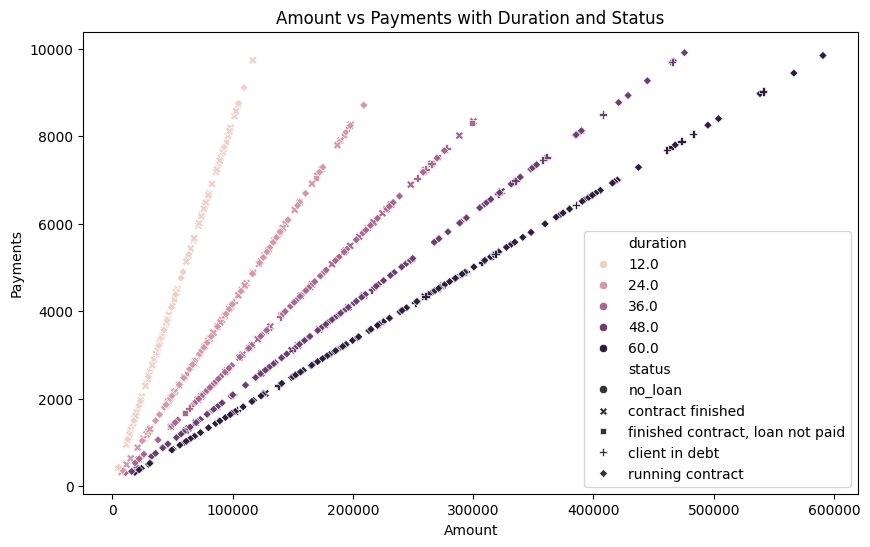

In [41]:
# visualize amount vs payments with duration and status
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=account_loan, x="amount", y="payments", hue="duration", style="status"
)
plt.title("Amount vs Payments with Duration and Status")
plt.xlabel("Amount")
plt.ylabel("Payments")
plt.show()

In [42]:
# join account_loan to client_disp_card_account
account_loan_client_disp_card_account = pd.merge(
    account_loan,
    client_disp_card_account,
    on="account_id",
    how="inner"
)
print(
    f"Number of rows in account_loan_client_disp_card_account df: {len(account_loan_client_disp_card_account)}"
)

Number of rows in account_loan_client_disp_card_account df: 3785


In [43]:
# join district to account_loan_client_disp_card_account
account_loan_client_disp_card_account_district = pd.merge(
    account_loan_client_disp_card_account,
    district,
    on="district_id",
    how="inner",
    suffixes=(".account_loan_client_disp_card_account", ".district"),
)
print(
    f"Number of rows in account_loan_client_disp_card_account_district df: {len(account_loan_client_disp_card_account_district)}"
)

Number of rows in account_loan_client_disp_card_account_district df: 3785


In [44]:
# join order to account_loan_client_disp_card_account
account_loan_client_disp_card_account_distric_order = pd.merge(
    account_loan_client_disp_card_account_district,
    merged_order,
    on="account_id",
    how="inner",
    suffixes=(".account_loan_client_disp_card_account_district", ".order"),
)
print(
    f"Number of rows in account_loan_client_disp_card_account_order df: {len(account_loan_client_disp_card_account_distric_order)}"
)

Number of rows in account_loan_client_disp_card_account_order df: 3785


In [45]:
# interactiv table deaaktive


account_loan_client_disp_card_account_distric_order.columns

Index(['account_id', 'district_id', 'issuance_statement_frequency_x',
       'date.account', 'loan_id', 'date.loan', 'amount', 'duration',
       'payments', 'status', 'num_of_loan', 'client_id', 'district_id.client',
       'disp_id', 'birth_number', 'gender', 'birth_day', 'age', 'type.disp',
       'card_id', 'type.card', 'issued', 'district_id.account',
       'issuance_statement_frequency_y', 'date', 'district_name', 'region',
       'num_of_habitat', 'num_of_small_town', 'num_of_medium_town',
       'num_of_big_town', 'num_of_bigger_town', 'num_of_city',
       'ratio_of_urban', 'average_salary', 'unemploy_rate95',
       'unemploy_rate96', 'n_of_enterpren_per1000_inhabit', 'no_of_crimes95',
       'no_of_crimes96', 'sum_amount', 'mean_amount', 'median_amount',
       'min_amount', 'max_amount', 'num_of_orders', 'has_order', 'Household',
       'Insurance Payment', 'Loan Payment', 'UNKNOWN'],
      dtype='object')

In [46]:
# Drop 'trans_id' and 'account' columns and sort by 'account_id'
trans = trans.drop(columns=["trans_id", "account"]).sort_values("account_id")

trans

,account_id,date,type,operation,amount,balance,k_symbol,bank
280771,1,1996-02-17,credit,credit in cash,100.0,14906.5,NaN,NaN
655184,1,1997-09-30,withdrawal,cash withdrawal,14.6,16752.0,statement payment,NaN
717942,1,1997-12-13,credit,collection from another bank,3679.0,14748.7,NaN,AB
475595,1,1997-01-30,withdrawal,cash withdrawal,840.0,12776.9,NaN,NaN
409957,1,1996-10-31,credit,NaN,73.2,16798.1,interest credited,NaN
...,...,...,...,...,...,...,...,...
537811,11382,1997-04-30,credit,NaN,97.5,24604.3,interest credited,NaN
299871,11382,1996-03-31,credit,NaN,76.8,20716.9,interest credited,NaN
416410,11382,1996-11-12,withdrawal,cash withdrawal,27700.0,32133.4,NaN,NaN
657165,11382,1997-09-30,credit,NaN,118.5,34255.3,interest credited,NaN


## Target Customer Search

## Split of the dataset

In [47]:
# stratified data split

In [48]:
# %% convert pyscript to notebook
#!jupytext --to notebook clean-tech-rag.py
# command with os
import os

# %%
#!jupyter nbconvert --to html --template pj "clean-tech-rag.ipynb"
# command with os
os.system("jupyter nbconvert --to html --template pj AML_MC.ipynb")
# %%

0